<a href="https://colab.research.google.com/github/Clalloures/100daysofcode/blob/master/k_means_em_imagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-means Clustering para análise de imagens

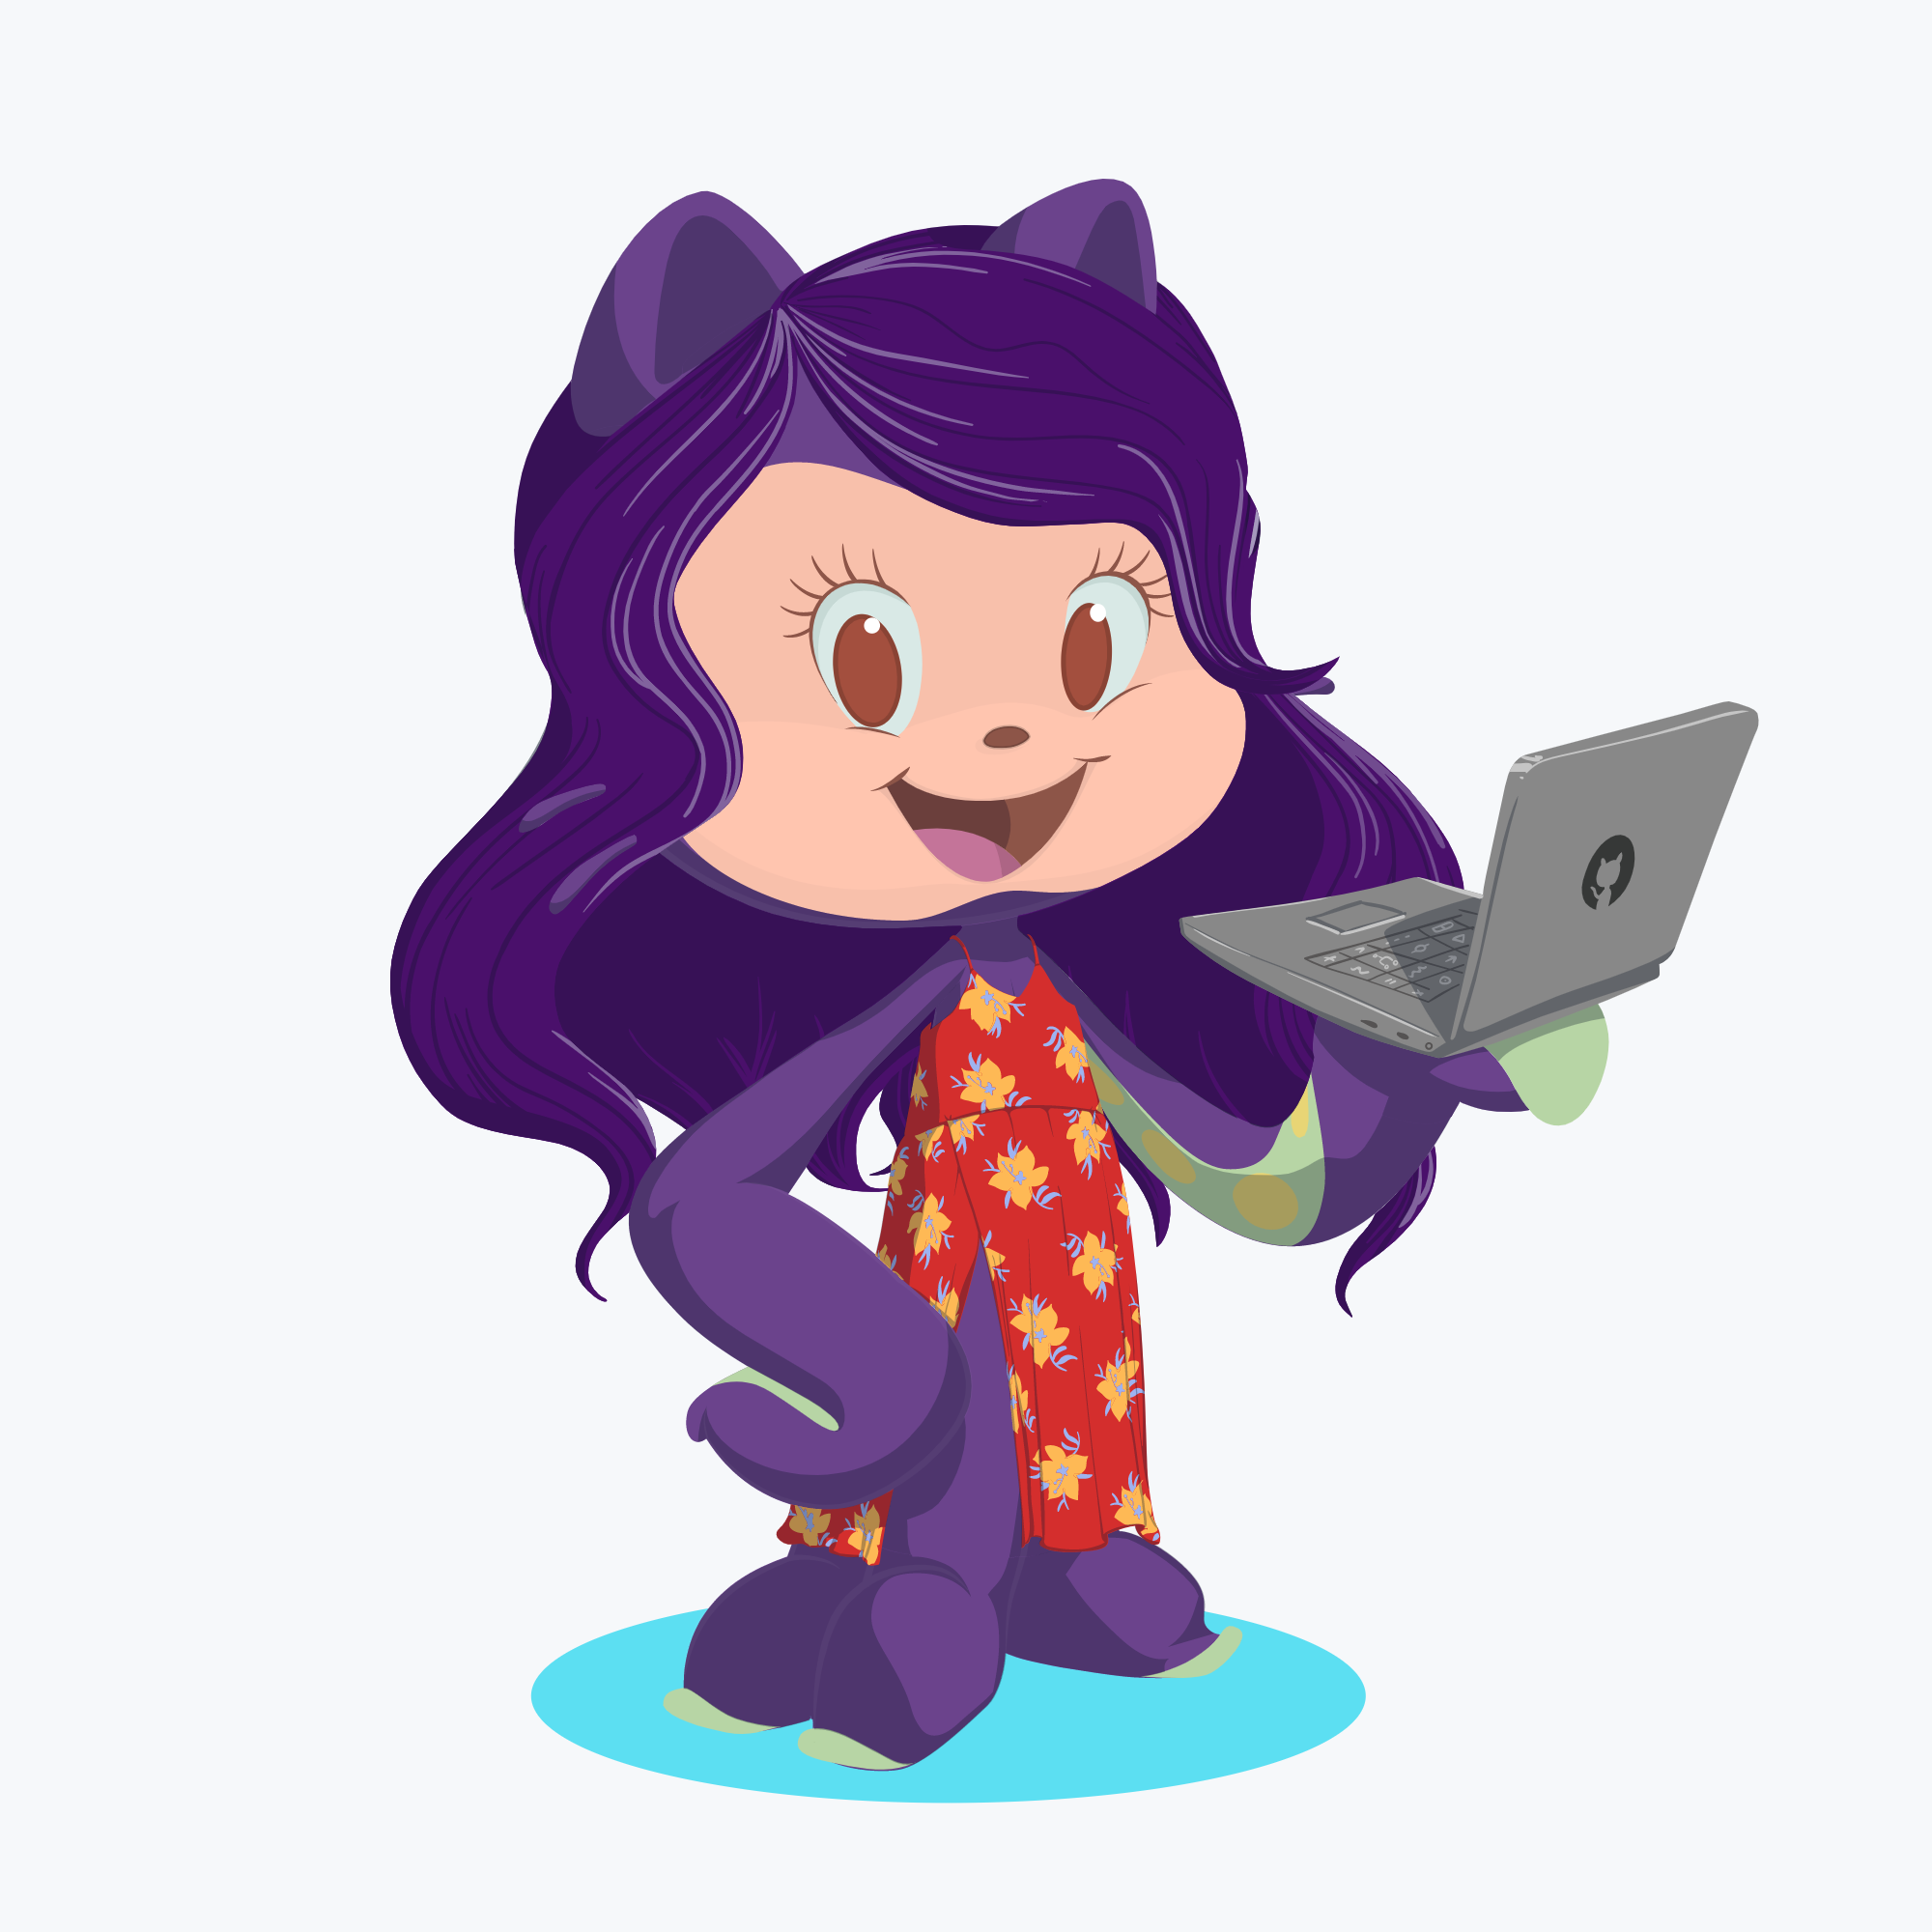

O primeiro passo é o básico de todos os tutoriais daqui, importar as bibliotecas

In [40]:
import sys
import sklearn
import matplotlib
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
# python magic function
%matplotlib inline

Neste projeto, usaremos um algoritmo K-means para realizar a classificação de imagens. 
Vamos utilizar o Scikit-learn e o conjunto de dados MNIST.
Este conjunto de dados tem diversos exemplos dos números 0 até 9 escritos a mão. É um dataset bem famoso e utilizado por muitos durante os primeiros projetos de Visão Computacional e Machine Learning.


## 1. Importar o dataset MNTST

Como dito, para este projeto, usaremos o conjunto de dados MNIST. Ele está disponível através do keras, uma biblioteca de aprendizado profundo. Também é possível acessar o dataset pelo tensorflow ou fazer o download em http://yann.lecun.com/exdb/mnist/.

In [41]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('Valores dos dados de treinamento: {}'.format(x_train.shape))
print('Labels de treinamento: {}'.format(y_train.shape))
print('Labels de teste: {}'.format(y_test.shape))

Valores dos dados de treinamento: (60000, 28, 28)
Labels de treinamento: (60000,)
Labels de teste: (10000,)


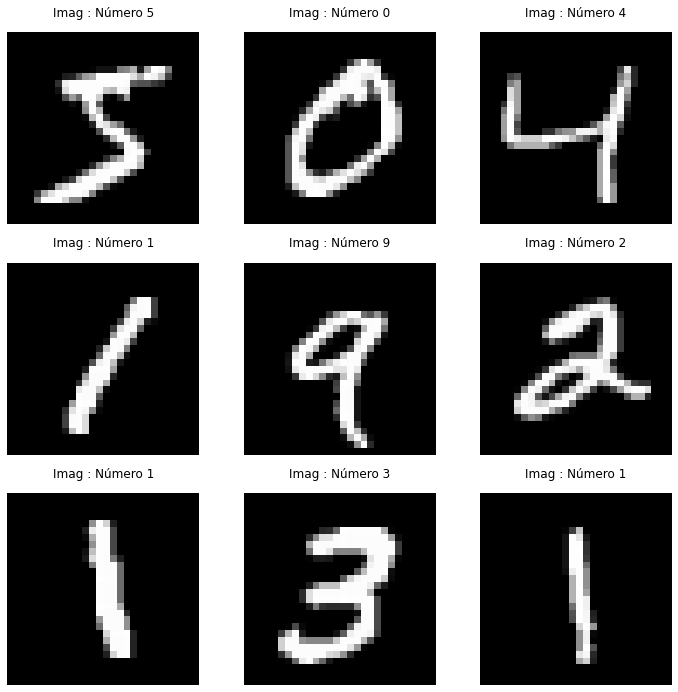

In [42]:
# criar figura com subplots 3x3 usando matplotlib.pyplot
figura, aux = plt.subplots(3, 3, figsize = (12, 12))
plt.gray()

# Percorrendo o subplots e adicionando as imagens MNIST
for i, aux in enumerate(aux.flat):
    aux.matshow(x_train[i])
    aux.axis('off')
    aux.set_title('Imag : Número {}'.format(y_train[i]))
    
# display the figure
figura.show()

## Pré-processamento das imagens
As imagens armazenadas como arrays NumPy são arrays bidimensionais. No entanto, o algoritmo de agrupamento K-means fornecido pelo scikit-learn ingere arrays unidimensionais; como resultado, precisaremos remodelar cada imagem. Os algoritmos de agrupamento quase sempre usam dados unidimensionais. 

In [43]:
# converter cada imagem em uma matriz de 1 dimensão 
X = x_train.reshape(len(x_train),-1)
Y = y_train
# normalize os dados para valores 0 - 1
X = X.astype(float) / 255.

## K-Means Clustering

Devido ao tamanho do conjunto de dados MNIST, usaremos mini-batch no k-means fornecido pelo scikit-learn. Isso reduzirá drasticamente o tempo necessário para ajustar o algoritmo aos dados.

O conjunto de dados MNIST contém imagens dos inteiros de 0 a 9. Por isso, vamos começar definindo o número de clusters em 10, um para cada dígito.
[0,1,2,3,4,5,6,7,8,9]


In [44]:
tamanho_digit = len(np.unique(y_test))
# Inicializando o modelo KMeans
kmeans = MiniBatchKMeans(n_clusters = tamanho_digit)
# Ajustando o modelo aos dados de treinamento
kmeans.fit(X)
kmeans.labels_

array([9, 5, 0, ..., 3, 4, 9], dtype=int32)

## Atribuição de rótulos de cluster

Como sabemos K-means é um método de aprendizado não supervisionado. Consequentemente, os rótulos atribuídos por nosso algoritmo K-means referem-se aos clusters aos quais cada array foia tribuido, e não o valor referente a reais dos dados. Para corrigir isso, vamos definir algumas funções que irão prever qual número inteiro corresponde a cada cluster.<br>

A primeira função, associa o rótulo mais provável a cada cluster no modelo K-Means e retorna um dicionário de clusters atribuído a cada rótulo

In [45]:
def clusterLab(kmeans, actual_labels):

    Inf_labels = {}
    for i in range(kmeans.n_clusters):
        # encontrar índice de pontos no cluster e anexar rótulos reais para cada ponto no cluster
        labels = []
        index = np.where(kmeans.labels_ == i)
        labels.append(actual_labels[index])
        # Determinar o rótulo mais comum
        if len(labels[0]) == 1:
            contador = np.bincount(labels[0])
        else:
            contador = np.bincount(np.squeeze(labels))
        # atribuir o cluster a um valor no dicionário Inf_labels
        if np.argmax(contador) in Inf_labels:
            Inf_labels[np.argmax(contador)].append(i)
        else:
            Inf_labels[np.argmax(contador)] = [i]  
    return Inf_labels  

def dataLab(X_labels, cluster_labels):
    Predi_labels = np.zeros(len(X_labels)).astype(np.uint8)
    for i, cluster in enumerate(X_labels):
        for inf, valor in cluster_labels.items():
            if cluster in valor:
                Predi_labels[i] = inf             
    return Predi_labels

## Otimizando e Avaliando o Algoritmo de Clustering
Com as funções definidas acima, podemos agora determinar a precisão de nossos algoritmos. Como estamos usando esse algoritmo de agrupamento para classificação, a precisão é, em última análise, a métrica mais importante; no entanto, existem outras métricas por aí que podem ser aplicadas diretamente aos próprios clusters, independentemente dos rótulos associados. Duas dessas métricas que usaremos são a inércia e a homogeneidade.<br>
<br>
Além disso, antes assumimos que K = 10 era o número apropriado de clusters; entretanto, pode não ser o caso. Vamos ajustar o algoritmo de agrupamento K-means com vários valores diferentes de K, em seguida, avaliar o desempenho usando nossas métricas.

In [46]:
def dados(data,teste, labels):
    print('Inercia: {}'.format(teste.inertia_))
    print('Homogeneidade: {}'.format(metrics.homogeneity_score(labels, teste.labels_)))
    print('Clusteres: {}'.format(teste.n_clusters))

In [47]:
clusters = [10, 16, 36, 64, 144, 256]
# test different numbers of clusters
for n_clusters in clusters:
    teste = MiniBatchKMeans(n_clusters = n_clusters)
    teste.fit(X) 
    # print cluster metrics
    dados(X,teste, Y)
    # determine predicted labels
    cluster_labels = infer_cluster_labels(teste, Y)
    predi_Y = dataLab(teste.labels_, cluster_labels)
    # calculate and print accuracy
    print('Precisão: {}\n'.format(metrics.accuracy_score(Y, predi_Y)))

Inercia: 2380884.7746645035
Homogeneidade: 0.442848154577347
Clusteres: 10
Precisão: 0.5534833333333333

Inercia: 2199029.2016476886
Homogeneidade: 0.5659268911115232
Clusteres: 16
Precisão: 0.654

Inercia: 1964361.4176002895
Homogeneidade: 0.6877536591747189
Clusteres: 36
Precisão: 0.76975

Inercia: 1814750.169395164
Homogeneidade: 0.7423859888420646
Clusteres: 64
Precisão: 0.8135166666666667

Inercia: 1630261.1086093795
Homogeneidade: 0.8046913990366303
Clusteres: 144
Precisão: 0.8685833333333334

Inercia: 1514238.2263888032
Homogeneidade: 0.8412712477127153
Clusteres: 256
Precisão: 0.8952333333333333



In [48]:
# teste o algoritmo kmeans no conjunto de dados de teste converter cada imagem em uma matriz dimensional
X_test = x_test.reshape(len(x_test),-1)
# normaliza os dados para 0 - 1
X_test = X_test.astype(float) / 255.
# inicializar e ajustar o algoritmo KMeans nos dados de treinamento
kmeans = MiniBatchKMeans(n_clusters = 256)
kmeans.fit(X)
cluster_labels = clusterLab(kmeans, Y)
# rótulos de previsão para dados de teste
clusteres_test = kmeans.predict(X_test)
labels_predi = dataLab(kmeans.predict(X_test), cluster_labels)
# calcular e imprimir a precisão
print('Precisão: {}\n'.format(metrics.accuracy_score(y_test, labels_predi)))

Precisão: 0.8899



## Visualizando Centroides dos Clusteres

O ponto mais representativo dentro de cada cluster é chamado de centróide. Se estivéssemos lidando com pontos X, Y, o centróide seria simplesmente um ponto no gráfico. No entanto, como estamos usando matrizes de comprimento 784, nosso centróide também será uma matriz de comprimento 784. Podemos remodelar essa matriz de volta em uma imagem de 28 por 28 pixels e plotá-la.<br><br>

Esses gráficos exibirão a imagem mais representativa de cada cluster.

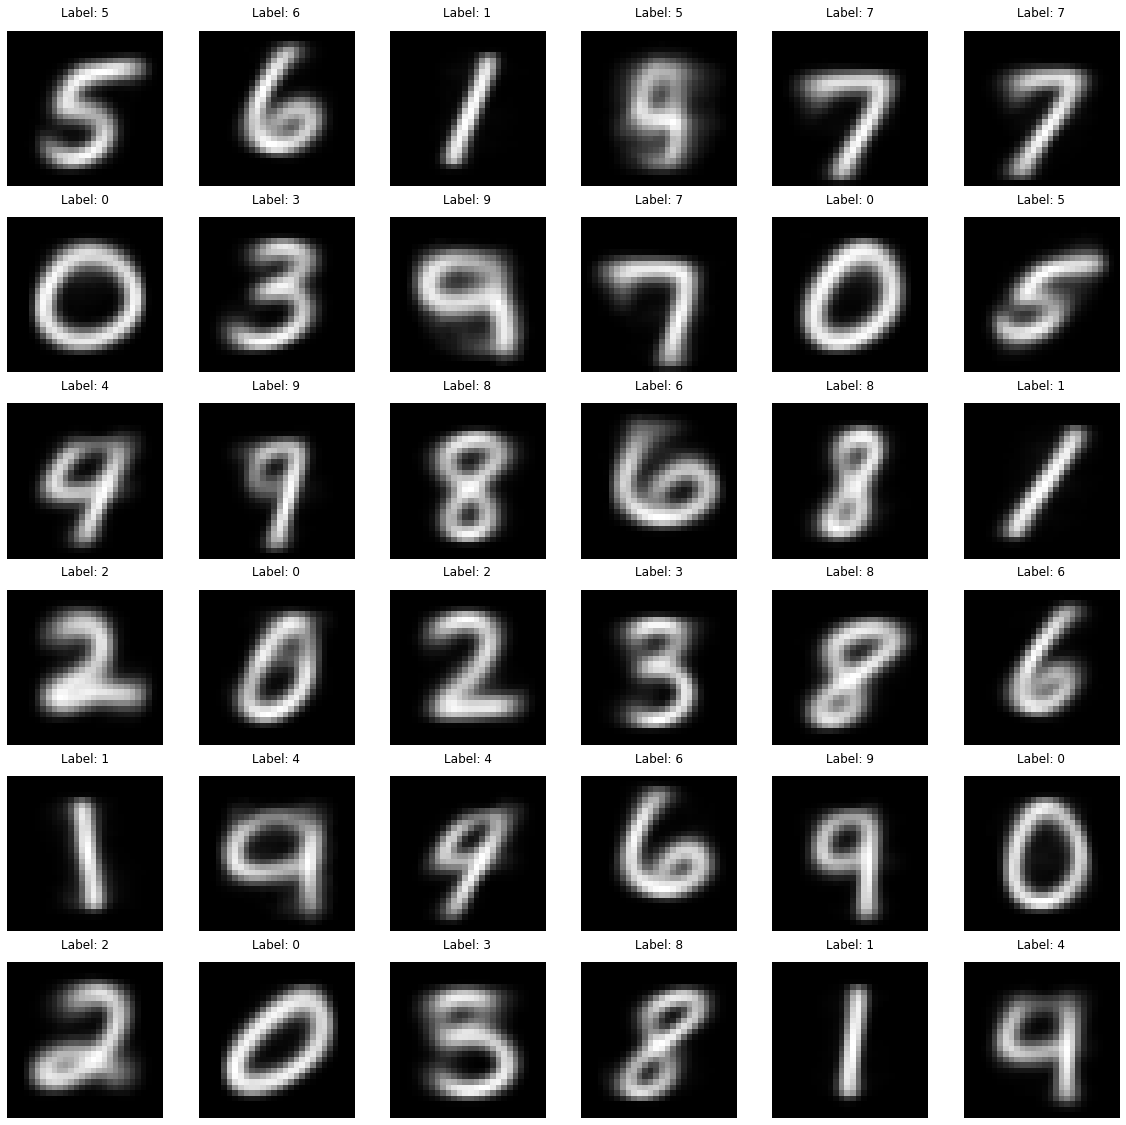

In [49]:
kmeans = MiniBatchKMeans(n_clusters = 36)
kmeans.fit(X)

# registro de valores de centroide
centroide = kmeans.cluster_centers_
# remodelar centróides em imagens
imagens = centroide.reshape(36, 28, 28)
imagens *= 255
imagens = imagens.astype(np.uint8)

# determina rótulos de cluster
cluster_labels = clusterLab(kmeans, Y)
# criar figura com subtramas usando matplotlib.pyplot
fig, auxs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()
# percorre subtramas e adiciona imagens de centroide
for i, aux in enumerate(auxs.flat):
    # determine inferred label using cluster_labels dictionary
    for inf, valor in cluster_labels.items():
        if i in valor:
            aux.set_title('Label: {}'.format(inf))
    # adicionar imagem ao subplot
    aux.matshow(imagens[i])
    aux.axis('off')
# exibir a figura
fig.show()